In [750]:
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from mplsoccer.pitch import Pitch, VerticalPitch
import seaborn as sns
import json

import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
import matplotlib.colors as mcolors
from matplotlib import cm
from highlight_text import fig_text, ax_text
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib import cm
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from tabulate import tabulate


# We'll only use a vertical pitch for this tutorial
from PIL import Image
import urllib
import json
import os


In [751]:
FILE = './Passmap/data/bre-ars.json'
PLAYER_NAME ='Granit Xhaka'
HA ='away'
MW = 7
SEASON ='PL 22-23'

TOUCH_ID = 91
ASSIST_ID = [92,47,48,49,50,51,52]
KEY_PASS = [39,40,41,42,43,44,45,46]
GOAL = [25,26,27]

In [752]:
with open(FILE) as f:
    d = json.load(f)

In [753]:
player_dict = dict(d['matchCentreData']['playerIdNameDictionary'])

player_data = [(x, player_dict[x]) for x in player_dict]
player_data = pd.DataFrame(player_data, columns=['playerId', 'player_name'])
player_data['playerId'] = player_data['playerId'].astype('int64')
player_data

,playerId,player_name
0,121480,Thomas Strakosha
1,296240,Yoane Wissa
2,29026,Zanka
3,329554,Mads Roerslev
4,339674,Mathias Jensen
5,401168,Mikkel Damsgaard
6,353377,Bryan Mbeumo
7,298689,Vitaly Janelt
8,362124,Shandon Baptiste
9,320575,Saman Ghoddos


In [754]:
passing_data = [x for x in d['matchCentreData']['events']]
passing_data = pd.json_normalize(passing_data)
passing_data = passing_data.drop([ 'type.value','period.value','outcomeType.value', 'id'], axis =1)
passing_data = pd.merge(passing_data, player_data, on=['playerId'])

PLAYER_ID = passing_data[passing_data.player_name == PLAYER_NAME]['playerId'].iloc[1]
player_passes = passing_data.loc[passing_data.player_name == PLAYER_NAME, ['x', 'y', 'endX', 'endY', 'period.displayName',
                                                         'outcomeType.displayName', 'satisfiedEventsTypes', 'playerId']]

In [755]:
def find_teams(data):
    home_team = data['matchCentreData']['home']['name']
    away_team = data['matchCentreData']['away']['name']

    home_team_players = [x['playerId'] for x in data['matchCentreData']['home']['players']]
    away_team_players = [x['playerId'] for x in data['matchCentreData']['away']['players']]

    if(PLAYER_ID in home_team_players):
        team = home_team
        oppositon = away_team
    else:
        team = away_team
        oppositon = home_team
    return team, oppositon

playing_team, opp = find_teams(d)

In [756]:
colors = [
    '#D2E5FB',
    '#C8DAEE',
    '#B9CEE4',
    '#AAC4E0',
    '#9EBAD9',
    '#96B4D5',
    '#86A7CB',
    '#7B9EC4',
    '#7398C1',
    '#668CB5',
    '#557FAC',
    '#4975A5',
    '#4270A1',
    '#366496',
    '#285689',
    '#215083',
    '#1C4A7D',
    '#134173',
    '#0C3B6D',
    '#053161',
]
soc_cm = LinearSegmentedColormap.from_list('SOC', colors, N=50)
cm.register_cmap(name='SOC', cmap=soc_cm)

In [763]:
def assists(df, player_data):
    assist_data = pd.DataFrame()
    for index, row in df.iterrows():
        if any(elem in row.loc["satisfiedEventsTypes"] for elem in ASSIST_ID):
            assist_data = assist_data.append(row)
    assist_data = pd.merge(assist_data, player_data, on=['player_name'])
    return assist_data
            
def key_passes(df, player_data):
    key_data = pd.DataFrame()
    for index, row in df.iterrows():
        if any(elem in row.loc["satisfiedEventsTypes"] for elem in KEY_PASS):
            key_data = key_data.append(row)
    key_data = pd.merge(key_data, player_data, on=['player_name'])
    return key_data

def goals(df, player_data):
    goals = pd.DataFrame()
    for index, row in df.iterrows():
        if any(elem in row.loc["satisfiedEventsTypes"] for elem in GOAL):
            goals = goals.append(row)
    goals = pd.merge(goals, player_data, on=['player_name'])
    return goals

def goals(d, player_data):

    goal_data = [x for x in d['matchCentreData']['events'] if x['type']['displayName'] == 'Goal']

    goal_data = pd.json_normalize(goal_data)
    goal_data = goal_data.drop(['isGoal', 'type.value','period.value','outcomeType.value','type.displayName', 
                                'outcomeType.displayName', 'id', 'isShot', 'isTouch', 'qualifiers'], axis =1)
    goal_data = pd.merge(goal_data, player_data, on=['playerId'])
    return goal_data

def player_assists(df):
    assist_data = pd.DataFrame()
    for index, row in df.iterrows():
        if any(elem in row.loc["satisfiedEventsTypes"] for elem in ASSIST_ID):
            assist_data = assist_data.append(row)
    return assist_data
            
def player_key_passes(df):
    key_data = pd.DataFrame()
    for index, row in df.iterrows():
        if any(elem in row.loc["satisfiedEventsTypes"] for elem in KEY_PASS):
            key_data = key_data.append(row)
    return key_data

##PLAYER STATS
player_assists = player_assists(player_passes)
player_key_passes = player_key_passes(player_passes)

##STATS OF THE WHOLE MATCH
match_assists = assists(passing_data, player_data)
match_key_passes = key_passes(passing_data, player_data)
match_goals = goals(d, player_data)


C:\Users\jawah\AppData\Local\Temp\ipykernel_26160\1382863266.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  assist_data = assist_data.append(row)
C:\Users\jawah\AppData\Local\Temp\ipykernel_26160\1382863266.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  key_data = key_data.append(row)
C:\Users\jawah\AppData\Local\Temp\ipykernel_26160\1382863266.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  key_data = key_data.append(row)
C:\Users\jawah\AppData\Local\Temp\ipykernel_26160\1382863266.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  key_data = key_data.append(row)
C:\Users\jawah\AppData\Local\Temp\ipykernel_26160\1382

In [760]:
player_data_dict = dict(d['matchCentreData'][HA])

# INDIVIDUAL STATS OF PLAYERS

player_stats ={}
for player in player_data_dict['players']:
    player_rating = player['stats'].get('ratings')
    stat_metrics = player['stats'].keys()
    stat = {}
    stat['Name'] = player['name']
#     stat['player_rating'] = list(player_rating.values())[-1]
    if player_rating == None:
        stat['Rating'] = 3
    else:
        stat['Rating'] = round(list(player_rating.values())[-1], 1)
    if player['position'] =='DC' or player['position'] =='DL' or player['position'] =='DR' and player_rating != 3:
        if 'interceptions' in stat_metrics:
            stat['Interceptions'] = sum(player['stats']['interceptions'].values())
        if 'clearances' in stat_metrics:
            stat['Clearances']    = sum(player['stats']['clearances'].values())
        if 'touches' in stat_metrics:
            stat['Touches']       = sum(player['stats']['touches'].values())
        if 'passesAccurate' in stat_metrics:
            stat['Accurate Passes']  = sum(player['stats']['passesAccurate'].values())
        if 'tacklesTotal' in stat_metrics:
            stat['Tackles']  = sum(player['stats']['tacklesTotal'].values())
    
    if (player['position'] =='MC' or player['position'] =='DMC' or player['position'] =='Sub') and player_rating != 3:
        if player['playerId'] in match_goals['playerId'].unique():
            stat['Goals'] = (match_goals['playerId'] == player['playerId']).sum()  
        if player['playerId'] in match_assists['playerId_y'].unique():
            stat['Assists'] = (match_assists['playerId_y'] == player['playerId']).sum()  
        if 'touches' in stat_metrics:
            stat['Touches']  = sum(player['stats']['touches'].values())
        if 'passesKey' in stat_metrics:
            stat['Key Passes']  = sum(player['stats']['passesKey'].values())
        if 'passesAccurate' in stat_metrics:
            stat['Accurate Passes']  = sum(player['stats']['passesAccurate'].values())
        if 'tacklesTotal' in stat_metrics:
            stat['Tackles']  = sum(player['stats']['tacklesTotal'].values())
        if 'defensiveAerials' in stat_metrics:
            stat['defensiveAerials']  = sum(player['stats']['defensiveAerials'].values())
            
    if (player['position'] =='FW' or player['position'] =='AMR' or player['position'] =='AMC' or player['position'] =='AML') and player_rating != 3:
        if player['playerId'] in match_goals['playerId'].unique():
            stat['Goals'] = (match_goals['playerId'] == player['playerId']).sum()   
        if player['playerId'] in match_assists['playerId_y'].unique():
            stat['Assists'] = (match_assists['playerId_y'] == player['playerId']).sum()
        if 'touches' in stat_metrics:
            stat['Touches']  = sum(player['stats']['touches'].values())
        if 'passesAccurate' in stat_metrics:
            stat['Accurate Passes']  = sum(player['stats']['passesAccurate'].values())
        if 'shotsTotal' in stat_metrics:
            stat['Shots']  = sum(player['stats']['shotsTotal'].values())
        if 'dribblesWon' in stat_metrics:
            stat['Dribbles completed']  = sum(player['stats']['dribblesWon'].values())
        if 'tacklesTotal' in stat_metrics:
            stat['Tackles']  = sum(player['stats']['tacklesTotal'].values())
        
            
#     print(list(player_rating.values())[-1])
    player_stats[player['name']] = stat
    
player_stats = pd.json_normalize(player_stats[PLAYER_NAME])

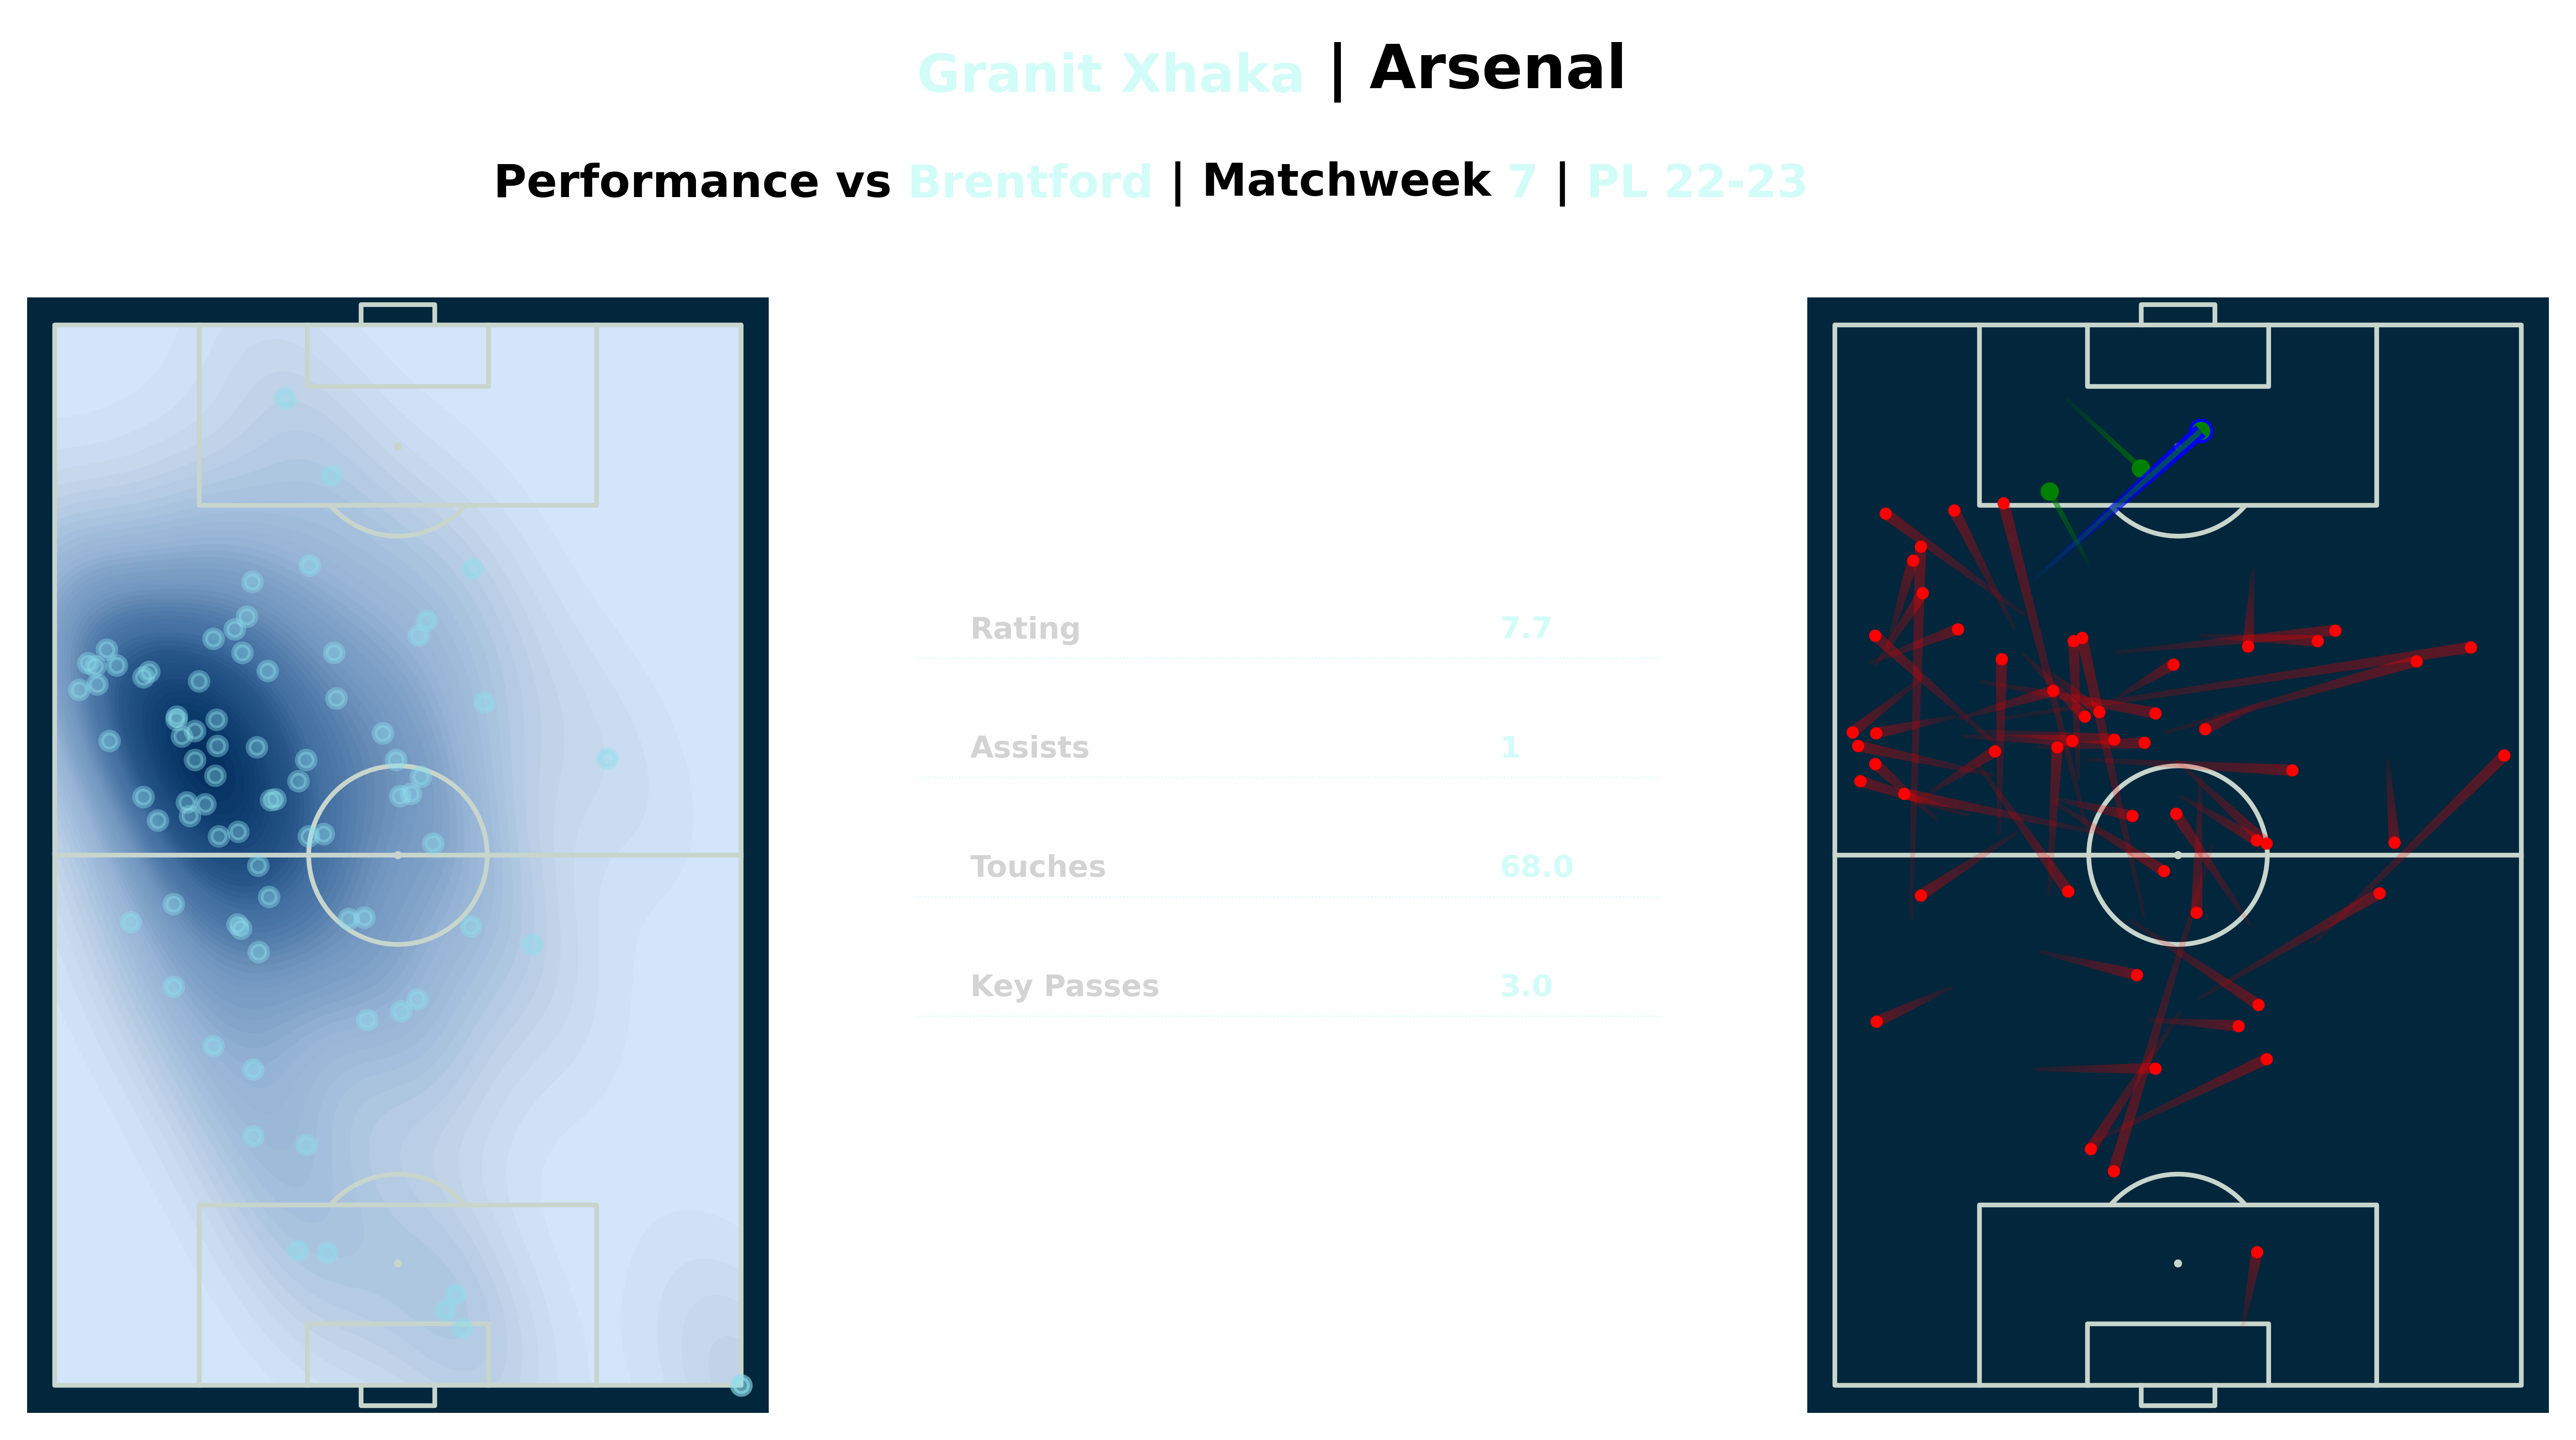

In [784]:
fig = plt.figure(figsize = (12,6), dpi = 600)
G = gridspec.GridSpec(3, 3)


##TOUCHMAP
axes_1 = plt.subplot(G[:, 0])

pitch = VerticalPitch(
    pitch_type='opta',
    goal_type='box',
    linewidth=1.25,
    pitch_color='#02263b', 
    line_color='#c7d5cc'
)
pitch.draw(ax = axes_1)

# ax.hlines(y=100, xmax=100, xmin=80)

pitch.kdeplot(
    player_passes.x, player_passes.y , 
    ax=axes_1, shade=True, 
    levels=300, shade_lowest=True,
    cut=6, zorder=-1, cmap='SOC')


first_half_touches = player_passes[player_passes['period.displayName'] =='FirstHalf']
second_half_touches = player_passes[player_passes['period.displayName'] =='SecondHalf']

##TOUCHES BY HALF
# ax.scatter(first_half_touches.y, first_half_touches.x, s=20, alpha=0.4, lw=1.5, color='#8edfed')
# ax.scatter(second_half_touches.y, second_half_touches.x, s=20, alpha=0.4, lw=1.5, color='#02fa72')

##TOUCHES BY MATCH
axes_1.scatter(player_passes.y, player_passes.x, s=20, alpha=0.4, lw=1.5, color='#8edfed')


##PASSMAP
axes_2 = plt.subplot(G[:, 2])

pitch = VerticalPitch(
    pitch_type='opta',
    goal_type='box',
    linewidth=1.25,
    pitch_color='#02263b', 
    line_color='#c7d5cc'
)
pitch.draw(ax = axes_2)

progressive_passes = player_passes[player_passes['x']< player_passes['endX']]
# other_passes = player_passes[player_passes['x'] >= player_passes['endX']]
player_passes_index = player_passes.index
key_passes_index = player_key_passes.index
assists_index = player_assists.index
mask = ~player_passes_index.isin(assists_index)
mask = ~player_passes_index.isin(key_passes_index)
other_passes = player_passes.loc[mask]


if(len(player_assists) != 0):
    pitch.lines(player_assists.x, player_assists.y,player_assists.endX, player_assists.endY, color='blue', 
           comet=True, ax = axes_2, transparent= True, lw= 4, alpha_start=0.05, alpha_end = 0.8)
    axes_2.scatter(player_assists.endY, player_assists.endX, lw=1, color='blue', s=30)


if(len(player_key_passes) != 0):
    pitch.lines(player_key_passes.x, player_key_passes.y,player_key_passes.endX, player_key_passes.endY, color='green', 
           comet=True, ax = axes_2, transparent= True, lw= 1.5, alpha_start=0.05, alpha_end = 0.4)
    axes_2.scatter(player_key_passes.endY, player_key_passes.endX, lw=1, color='green', s=15)


if(len(other_passes) != 0):
    pitch.lines(other_passes.x, other_passes.y,other_passes.endX, other_passes.endY, color='red', 
           comet=True, ax = axes_2, transparent= True, lw= 3, alpha_start=0.05, alpha_end = 0.2)
    axes_2.scatter(other_passes.endY, other_passes.endX, lw=0.1, color='red', s= 10)

##TABLE MIDDLE
axes_3 = plt.subplot(G[:-1, 1])

ncols = player_stats.shape[0]
nrows = player_stats.shape[1]-1

axes_3.set_xlim(0, nrows + 1)
axes_3.set_ylim(0, ncols + 1)
axes_3.set_axis_off()

positions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
columns = player_stats.columns[1:]

# Add table's main text
for y in range(0, nrows):
    axes_3.annotate(
        xy=(0.5, y*0.3 - 0.5),
        text=columns[len(columns) -y -1],
        ha='left',
        size=8,
        weight='light',
        color='lightgrey'
    )
    axes_3.annotate(
        xy=(5.5,y*0.3 - 0.5),
        text= player_stats[columns[len(columns) -y -1]].iloc[0],
        ha='left',
        size=8,
        color = '#d2fcf8',
        weight='bold'
    )

# axes_3.plot([axes_3.get_xlim()[0], axes_3.get_xlim()[1]], [ncols, ncols], lw=1.5, color='black', marker='', zorder=4)
# axes_3.plot([4, 4], [-0.5, 1.8], lw=1.5, color='black', marker='', zorder=4)
for x in range(0, nrows):
    axes_3.plot([axes_3.get_xlim()[0], axes_3.get_xlim()[1]], [x*0.3-0.55, x*0.3-0.55], lw=.35, color='#d2fcf8', ls=':', zorder=3 , marker='')

    
# ax_text(
#                 x = 1.2, 
#                 y = 0.7,
#                 s = f'<{PLAYER_NAME}>\n<Avg. xGF: {playing_team}',
#                 ax = axes_3, 
#                 highlight_textprops=[{'weight':'bold', 'font':'DM Sans'},{'size':'8'}],
#                 font = 'Karla', 
#                 ha = 'left', 
#                 size = 10, 
#                 annotationbbox_kw = {'xycoords':'axes fraction'}
#             )


ax_text(
        x=0, y=2.5,
        s=f"<{PLAYER_NAME}> | {playing_team}",
        highlight_textprops=[{'size':14, 'weight':'bold', 'color': '#d2fcf8'}],
        ax=axes_3,
        weight='bold',
        size=16,
        font='DM Sans',
        ha='left'
    )

ax_text(
        x=-4, y=2.2,
        s=f"Performance vs <{opp}> | Matchweek <{MW}> | <{SEASON}>",
        highlight_textprops=[{'size':12, 'weight':'bold', 'color': '#d2fcf8'}, {'size':12, 'weight':'bold', 'color': '#d2fcf8'},
                            {'size':12, 'weight':'bold', 'color': '#d2fcf8'}],
        ax=axes_3,
        weight='bold',
        size=12,
        font='DM Sans',
        ha='left'
    )
    
# fig_text(
#     x=0.17, y=.96, 
#     s='<{PLAYER_NAME}> | {playing_team}',
#     va='bottom', ha='left',
#     fontsize=19, color='black', font='DM Sans', weight='bold'
# )
# fig_text(
# x=0.17, y=.92, 
#     s='A point for every match in the League Two 2022/2023 season | Dashed points denote fixtures away from home',
#     va='bottom', ha='left',
#     fontsize=10, color='#4E616C', font='Karla'
# )
    
plt.savefig(
    './final_table_bkg.png',
    dpi=600,
    transparent=False,
    facecolor='#02263b',
    bbox_inches='tight'
)

,eventId,minute,second,teamId,x,y,expandedMinute,qualifiers,satisfiedEventsTypes,isTouch,...,blockedX,blockedY,goalMouthZ,goalMouthY,isShot,isGoal,cardType.value,cardType.displayName,player_name,playerId_y
7,40,1,23.0,13,93.1,66.4,1,"[{'type': {'value': 140, 'displayName': 'PassE...","[91, 119, 117, 30, 123, 205, 40, 46, 35, 38, 2...",True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Granit Xhaka,89401
8,292,27,0.0,13,75.8,71.2,27,"[{'type': {'value': 22, 'displayName': 'Regula...","[91, 92, 100, 119, 117, 30, 123, 124, 203, 205...",True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Granit Xhaka,89401
9,587,56,27.0,13,77.3,62.9,58,"[{'type': {'value': 213, 'displayName': 'Angle...","[91, 119, 117, 30, 123, 203, 205, 40, 46, 36, ...",True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Granit Xhaka,89401
